In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arrow
from scipy.signal import savgol_filter 
import numpy as np
from lmfit.models import SkewedGaussianModel

In [2]:
# data from: http://ncov.mohw.go.kr/
df = pd.read_csv("all.csv").loc[1:].reset_index()
df["counts"] = [float(c.replace(",", "")) for c in df["계(명)"]]
df["savgol"] = savgol_filter([float(c.replace(",", "")) for c in df["계(명)"]], 7, 2)
df["ts"] = pd.to_datetime([str(arrow.get(t)) for t in df["일자"]])
df["rolling_avg"] = df["counts"].rolling(7).mean()

In [24]:
def skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=False):
    window_length = len(df) - start_idx
    april = pd.to_datetime([f"2022-04-{x}T00:00:00+00:00'" for x in range(1,31)]).to_list()
    may = pd.to_datetime([f"2022-05-{x}T00:00:00+00:00'" for x in range(1,32)]).to_list()
    whole_date = df["ts"].to_list() + april + may

    whole_date = sorted(list(set(whole_date)))
    xvals = np.arange(0, window_length)
    yvals = target_y[start_idx:]


    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=13639305., center=102.12, sigma=22.41, gamma=0)

    # adjust parameters  to best fit data.
    result = model.fit(yvals, params, x=xvals)
    
    if show_stats:
        print(result.fit_report())

    plt.figure(figsize=(6.5, 5))
    plt.title("fitting")
    plt.plot(xvals, yvals, 'd')
    ex = result.eval(x=xvals)
    plt.plot(xvals, ex)


    plt.figure(figsize=(10, 5))

    expected = result.eval(x=np.arange(-20, window_length+35))

    plt.plot(whole_date[start_idx-20:start_idx+window_length],  target_y[start_idx-20:], 'd', label="daily Covid cases")
    plt.plot(whole_date[start_idx-20:start_idx+window_length+35], expected, label="fitting")
    plt.legend()
    plt.title("Forcasting Korean Covid cases")
    plt.xticks(whole_date[start_idx-20:start_idx+window_length+35][::15])

## 7-day rolling avg & original confirmed cases

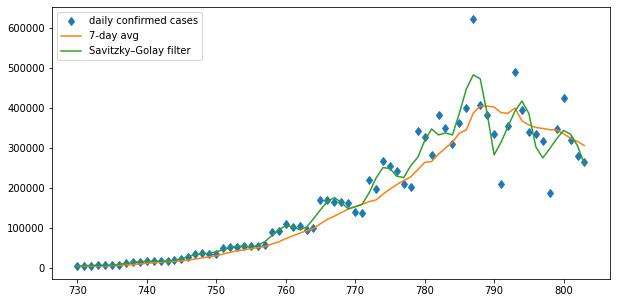

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df.counts[730:], 'd', label="daily confirmed cases")
df.rolling_avg[730:].plot(label="7-day avg")
df.savgol[730:].plot(label="Savitzky–Golay filter")
plt.legend()

## skewed normal fifting using original data

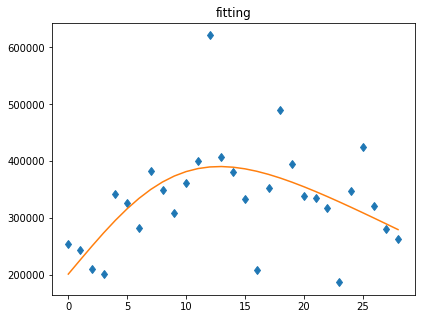

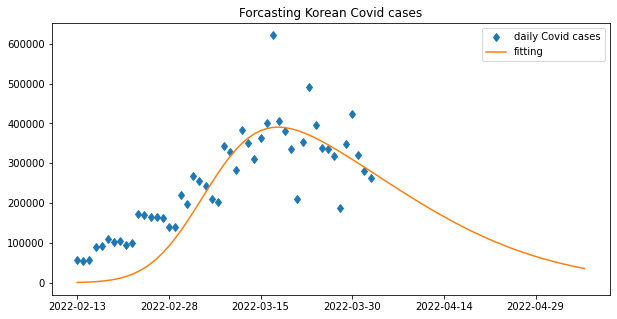

In [26]:
target_y = df.counts
start_idx = 775

skewed_gaussian_fitting_n_plot(target_y, 775, df)

## skewed normal fifting using 7-day rolling avg

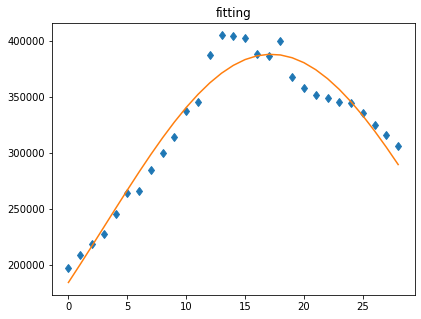

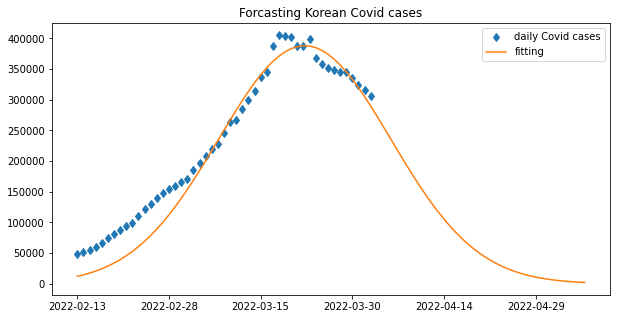

In [27]:
target_y = df.rolling_avg
start_idx = 775

skewed_gaussian_fitting_n_plot(target_y, 775, df)

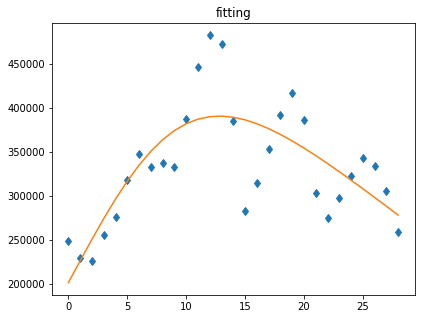

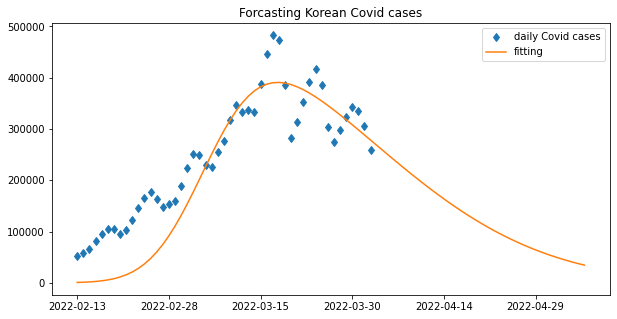

In [28]:
target_y = df.savgol
start_idx = 775

skewed_gaussian_fitting_n_plot(target_y, 775, df)